In [135]:
import numpy as np
import scipy.fftpack as fft
import matplotlib.pyplot as plt
from scipy.signal import get_window

In [155]:
from ipynb.fs.full.preparation import get_librosa_audio, get_audio_path

sr = 16000
audio_paths = get_audio_path()
audio_librosa = get_librosa_audio(sr = sr)

In [139]:
def frame_audio(audio, fft_size = 2048, hop_size = 10, sample_rate = sr):
    audio = np.pad(audio, fft_size // 2, mode = 'reflect')
    frame_length = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - fft_size) / frame_length) + 1
    frames = np.zeros((frame_num, fft_size))

    for n in range(frame_num):
        frames[n] = audio[n * frame_length : n * frame_length + fft_size]
    
    return frames

In [153]:
hop_size = 15
fft_size = 2048

audio_framed = {}
for key, values in audio_librosa.items():
    audio_framed[key] = [frame_audio(value[0], fft_size = fft_size, hop_size = hop_size, sample_rate = sr) for value in values]

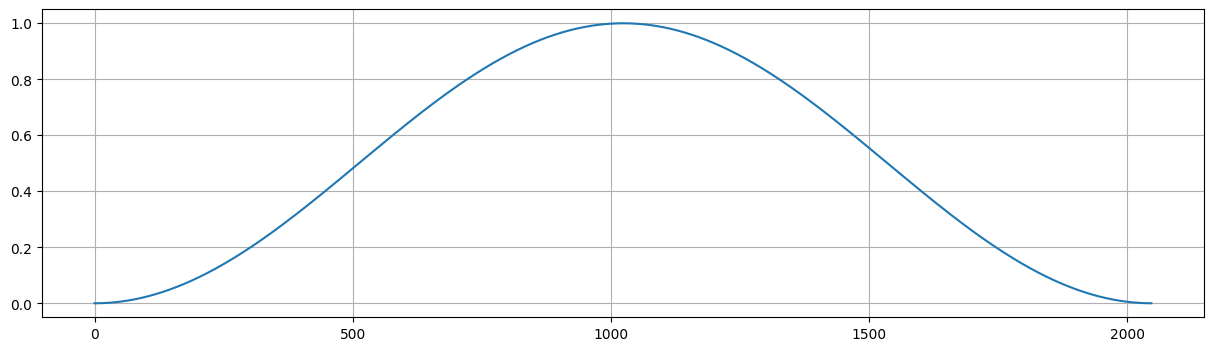

In [154]:
window = get_window('hann', fft_size, fftbins = True)
plt.figure(figsize = (15, 4))
plt.plot(window)
plt.grid(True)

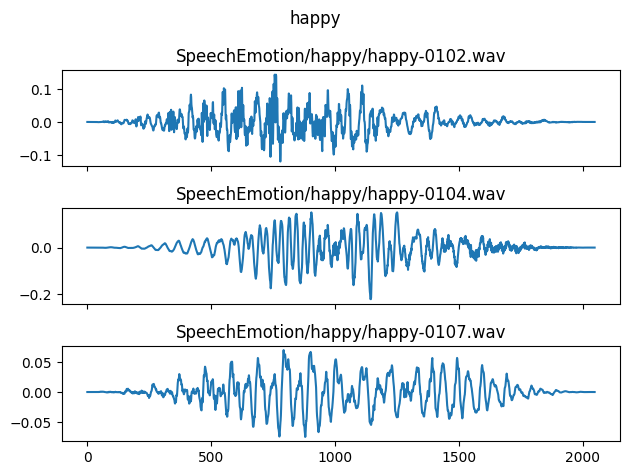

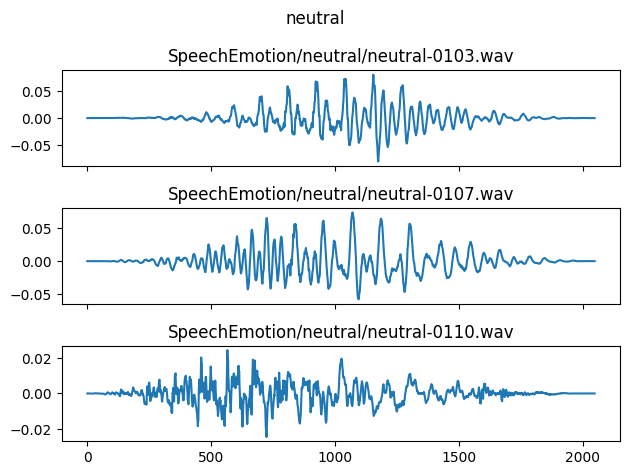

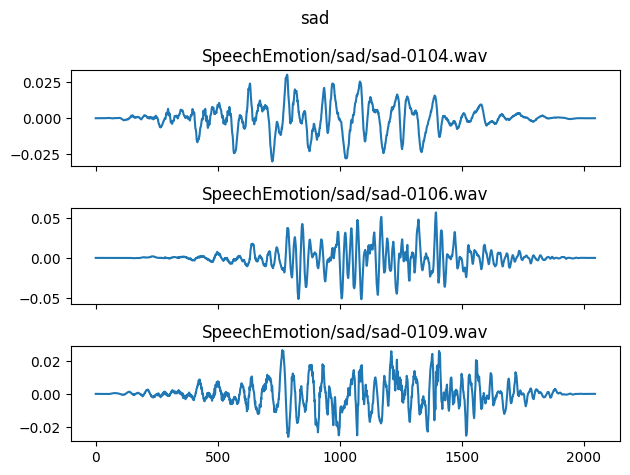

In [160]:
def get_windowed_audio(audio_framed, window):
    audio_win = audio_framed * window
    return audio_win

def display_windowed_audio(emotion, waves):
    fig, ax = plt.subplots(nrows = len(waves), ncols = 1, sharex = True)
    fig.suptitle(emotion)
    idx = 70
    for i, wave in enumerate(waves):
        ax[i].plot(wave[idx])
        ax[i].set_title(audio_paths[emotion][i])
    fig.tight_layout()

audio_windowed = {}
for key, values in audio_framed.items():
    audio_windowed[key] = [get_windowed_audio(value, window = window) for value in values]
    display_windowed_audio(key, audio_windowed[key])
    

In [164]:
def get_fft(windowed_audio):
    windowed_t = np.transpose(windowed_audio)
    audio_fft = np.empty((int(1 + fft_size // 2), windowed_t.shape[1]), dtype = np.complex64, order = 'F')

    for n in range(audio_fft.shape[1]):
        audio_fft[:, n] = fft.fft(windowed_t[:, n], axis = 0)[:audio_fft.shape[0]]
    
    audio_fft = np.transpose(audio_fft)
    return audio_fft

audio_fft = {}
for key, values in audio_windowed.items():
    audio_fft[key] = [get_fft(value) for value in values]

In [182]:
audio_power = {}
for key, values in audio_fft.items():
    audio_power[key] = [np.square(np.abs(value)) for value in values]

f_min = 0
f_high = sr / 2
mel_filter_num = 10

In [168]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def mel_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [172]:
def get_filter_points(f_min, f_max, mel_filter_num, fft_size, sample_rate = 16000):
    min_mel = freq_to_mel(f_min)
    max_mel = freq_to_mel(f_max)

    mels = np.linspace(min_mel, max_mel, num = mel_filter_num + 2)
    freqs = mel_to_freq(mels)

    return np.floor((fft_size + 1) / sample_rate * freqs).astype(int), freqs

filter_points, mel_freqs = get_filter_points(f_min = f_min, f_max = f_high, mel_filter_num = mel_filter_num, fft_size = fft_size, sample_rate = 16000)

In [173]:
def get_filters(filter_points, fft_size):
    filters = np.zeros((len(filter_points) - 2, int(fft_size / 2 + 1)))

    for n in range(len(filter_points) - 2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])

    return filters

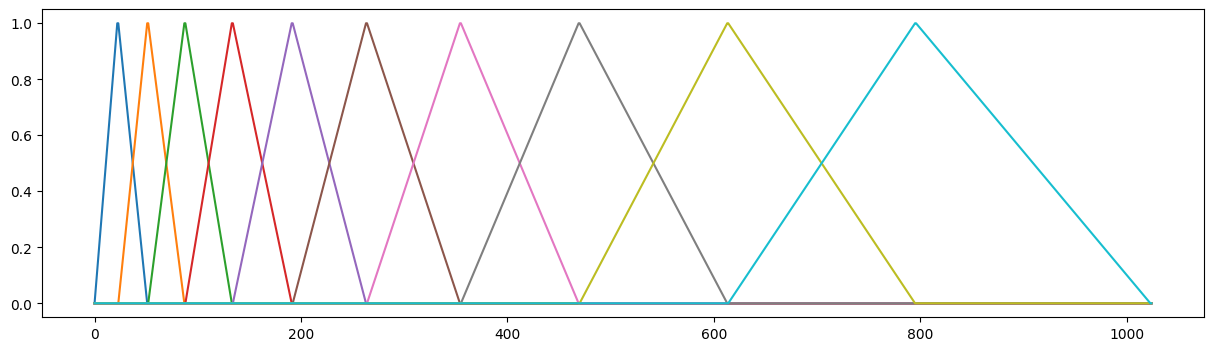

In [175]:
filters = get_filters(filter_points, fft_size)

plt.figure(figsize = (15, 4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

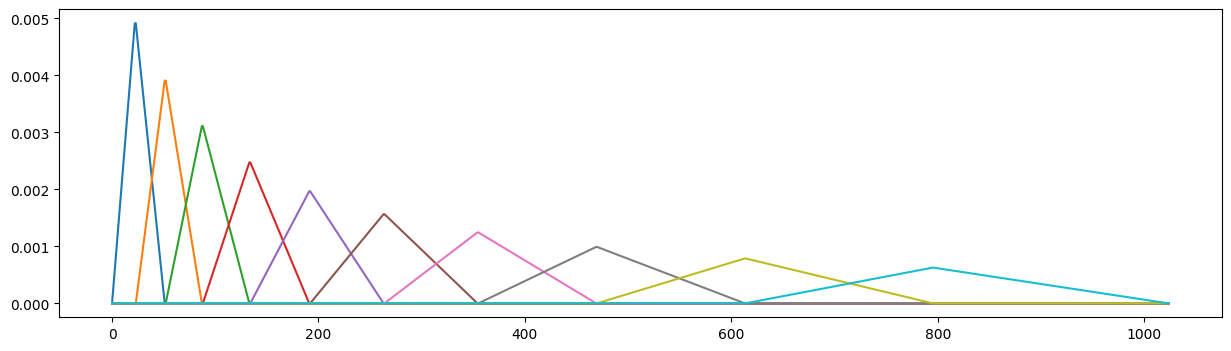

In [176]:
enomrm = 2.0 / (mel_freqs[2 : mel_filter_num + 2] - mel_freqs[:mel_filter_num])
filters *= enomrm[:, np.newaxis]

plt.figure(figsize = (15, 4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [184]:
audio_log = {}
for key, values in audio_power.items():
    audio_log[key] = []
    for value in values:
        audio_filtered = np.dot(filters, np.transpose(value))
        audio_log[key].append(10.0 * np.log10(audio_filtered))

In [178]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num, filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)

    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
    
    return basis

In [186]:
dct_filter_num = 40
dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficients = {}
for key, values in audio_log.items():
    cepstral_coefficients[key] = [np.dot(dct_filters, value) for value in values]

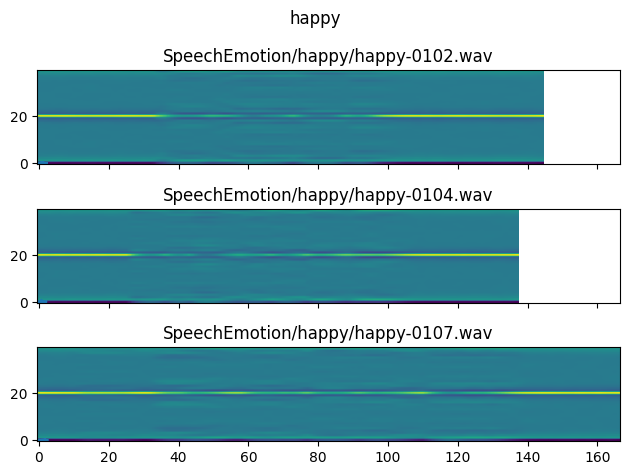

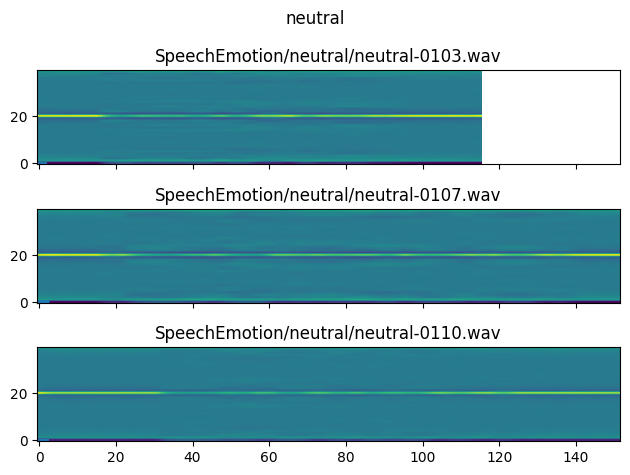

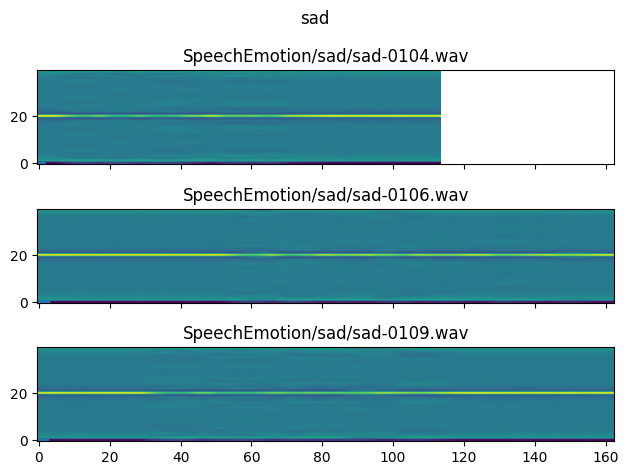

In [198]:
for key, values in audio_librosa.items():
    fig, ax = plt.subplots(nrows = len(values), ncols = 1, sharex = True)
    fig.suptitle(key)
    for i, value in enumerate(values):
        ax[i].set_title(audio_paths[key][i])
        ax[i].plot(np.linspace(0, len(value[0]) / sr, num = len(value[0])), value[0])
        ax[i].imshow(cepstral_coefficients[key][i], aspect = 'auto', origin = 'lower')

    fig.tight_layout()